
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Виталий Радченко, Data scientist @ YouScan (@vradchenko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала

# <center> Домашнее задание № 5 (Демо).
## <center> Логистическая регрессия и случайный лес в задаче кредитного скоринга

[Веб-форма](https://docs.google.com/forms/d/1HASy2b_FLBHBCzzpG-TbnbB6gqhB-qwznQxU2vaoSgc/) для ответов.

#### Нашей главной задачей будет построение модели для задачи кредитного скоринга.

Но для разминки решите первое задание :)

**Задание 1.** В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить, виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?
- 70.00%
- 83.20%
- 83.70%
- 87.50%

Теперь перейдем непосредственно к машинному обучению.

#### Данные представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	      – Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                          –  Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	 – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio  – 	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	 – Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate  – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse – 	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип -	integer
* NumberOfDependents  – Число человек в семье кредитозаёмщика; тип -	integer

In [1]:
import math

def comb(n, k):
    return math.factorial(n) / (math.factorial(k) * math.factorial(n-k))

n = 5
p = 0.7
m = math.floor(n/2) + 1
mu = 0

for i in range(m, n+1):
    mu += comb(n, i) * math.pow(p, i) * math.pow(1 - p, n - i)

print(f'{round(mu*100, 1):.2f}%')

83.70%


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [3]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы 
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

In [30]:
## Считываем данные
data = pd.read_csv('credit_scoring_sample.csv', sep=';')
data.head()

SeriousDlqin2yrs  age  NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  \
0                 0   64                                     0     0.249908   
1                 0   58                                     0  3870.000000   
2                 0   41                                     0     0.456127   
3                 0   43                                     0     0.000190   
4                 1   49                                     0     0.271820   

   NumberOfTimes90DaysLate  NumberOfTime60-89DaysPastDueNotWorse  \
0                        0                                     0   
1                        0                                     0   
2                        0                                     0   
3                        0                                     0   
4                        0                                     0   

   MonthlyIncome  NumberOfDependents  
0         8158.0                 0.0  
1            NaN                 0.0  
2         6666.0                 0.0  
3        10500.0                 2.0  
4          400.0                 0.0

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45063 entries, 0 to 45062
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      45063 non-null  int64  
 1   age                                   45063 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  45063 non-null  int64  
 3   DebtRatio                             45063 non-null  float64
 4   NumberOfTimes90DaysLate               45063 non-null  int64  
 5   NumberOfTime60-89DaysPastDueNotWorse  45063 non-null  int64  
 6   MonthlyIncome                         36420 non-null  float64
 7   NumberOfDependents                    43946 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 2.8 MB


In [32]:
data = data.drop(data[data['DebtRatio'] > 1].index).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34071 entries, 0 to 45062
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      34071 non-null  int64  
 1   age                                   34071 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  34071 non-null  int64  
 3   DebtRatio                             34071 non-null  float64
 4   NumberOfTimes90DaysLate               34071 non-null  int64  
 5   NumberOfTime60-89DaysPastDueNotWorse  34071 non-null  int64  
 6   MonthlyIncome                         34071 non-null  float64
 7   NumberOfDependents                    34071 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 2.3 MB


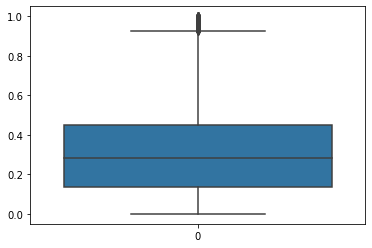

In [33]:
sns.boxplot(data=data['DebtRatio']);

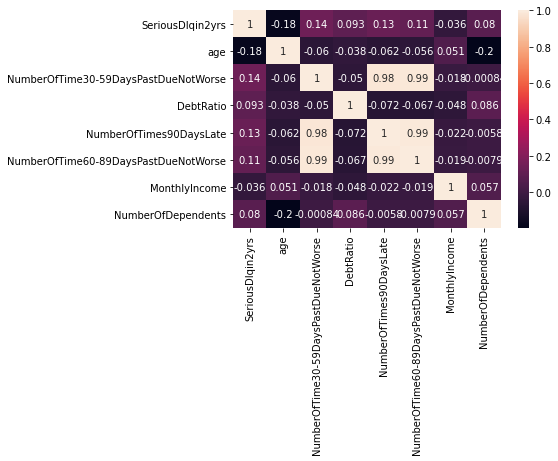

In [36]:
sns.heatmap(data.corr(), annot=True);

In [37]:
data.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse',
                  'NumberOfTime60-89DaysPastDueNotWorse'], inplace=True)

Distribution of target


0    0.776232
1    0.223768
Name: SeriousDlqin2yrs, dtype: float64

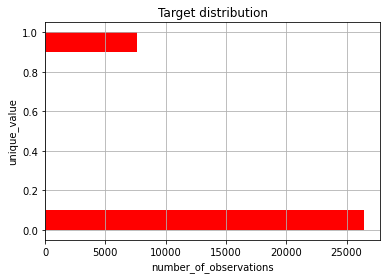

In [38]:
## Посмотрим на распределение классов в зависимой переменной

ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [39]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'MonthlyIncome',
 'NumberOfDependents']

In [41]:
## Разделяем таргет и признаки 
X = data[independent_columns_names]
y = data['SeriousDlqin2yrs']

# Бутстрэп

**Задание 2.** Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". Используйте пример из статьи, поставьте `np.random.seed(0)`, как это сделано в статье.

In [42]:
def get_bootstrap_samples(data, n_samples):
    np.random.seed(0)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [43]:
debtors = data[data['SeriousDlqin2yrs'] == 1]['age'].values
debtor_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(debtors, 1000)]

print("Возраст клиентов, просрочивших платёж:  интервал",  stat_intervals(debtor_mean_scores, 0.1))

Возраст клиентов, просрочивших платёж:  интервал [45.367117   45.84243835]


## Подбор параметров для модели логистической регрессии 

#### Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0  до 1.   Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны, 
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть 
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

**Задание 3.**
Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [45]:
lr_grid = GridSearchCV(lr, parameters, cv=skf, n_jobs=-1, scoring='roc_auc').fit(X, y)
lr_grid.best_params_

{'C': 0.01}

In [87]:
lr_grid.best_score_

0.7331008816155011

**Задание 4.** 
Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [46]:
idx = np.argmin(lr_grid.cv_results_['rank_test_score'])
print('модель устойчива:', lr_grid.cv_results_['std_test_score'][idx] < 0.005)

lr_score = lr_grid.best_score_

модель устойчива: False


## Определение влияния признаков

**Задание 5.**
Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [49]:
from sklearn.preprocessing import normalize

lr = lr.set_params(C=lr_grid.best_params_['C']).fit(normalize(X), y)
idx = np.argmax(np.abs(lr.coef_))
print(independent_columns_names[idx])

NumberOfTimes90DaysLate


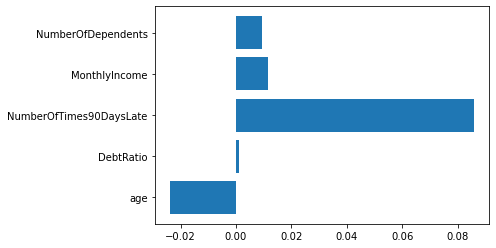

In [62]:
plt.barh(independent_columns_names, lr.coef_[0])
plt.show()

**Задание 6.** Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией [softmax](https://en.wikipedia.org/wiki/Softmax_function))

In [63]:
idx = independent_columns_names.index('DebtRatio')
softmax = np.exp(lr.coef_[0][idx]) / np.sum(np.exp(lr.coef_[0]))
print(f'{softmax:.2f}')

0.20


**Задание 7.** 
Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заново оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть [здесь](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf))

In [71]:
lr = lr.fit(X, y)
age_plus_20_ratio = np.exp(lr.coef_[0][independent_columns_names.index('age')]*20)
print(f'{age_plus_20_ratio:.2f}')

0.73


# Случайный лес

In [77]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами 
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            random_state=42, oob_score=True, 
                            class_weight='balanced')

## Будем искать лучшие параметры среди следующего набора
parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7, 9], 
              'max_depth': [5,10,15]}

## Делаем опять же стрэтифайд k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf
rf_grid = GridSearchCV(rf, parameters, cv=skf, n_jobs=-1, scoring='roc_auc').fit(X, y)
rf_grid.best_params_

{'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 9}

In [86]:
rf_grid.best_score_

0.7609554375598412

**Задание 8.** На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [78]:
diff = rf_grid.best_score_ - lr_grid.best_score_
print(f'{diff*100:.2f}%')

2.79%


**Задание 9.** Определите какой признак имеет самое слабое влияние.

In [82]:
rf = rf.set_params(max_depth=rf_grid.best_params_['max_depth'],
                  max_features=rf_grid.best_params_['max_features'],
                  min_samples_leaf=rf_grid.best_params_['min_samples_leaf']).fit(X, y)
independent_columns_names[np.argmin(np.abs(rf.feature_importances_))]

'NumberOfDependents'

**Задание 10.** Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?

- меньше тратится времени для тренировки модели;
- меньше параметров для перебора;
- интепретируемость признаков;
- линейные свойства алгоритма.

1

# Бэггинг

In [83]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

**Задание 11.** Следующая задача обучить бэггинг классификатор (`random_state`=42). В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не `GridSearchCV`, а `RandomizedSearchCV`. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для `RandomizedSearchCV`. Также не забудьте передать параметр валидации `cv` и `random_state=1`. Какая лучшая точность получилась?

In [84]:
bg = BaggingClassifier(LogisticRegression(class_weight='balanced'),
                       n_estimators=100, n_jobs=-1, random_state=42)
bg_grid = RandomizedSearchCV(bg, parameters, n_jobs=-1, scoring='roc_auc',
                             cv=skf, n_iter=20, random_state=1).fit(X, y)
bg_grid.best_params_

{'max_samples': 0.9, 'max_features': 3, 'base_estimator__C': 100}

In [85]:
bg_grid.best_score_

0.747072951149803

**Задача 12.** Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?

- для бэггинга важно использовать как можно меньше признаков
- бэггинг лучше работает на небольших выборках
- меньше корреляция между одиночными моделями
- чем больше признаков, тем меньше теряется информации

3